# MultiStepLRScheduler

`MultiStepLRScheduler` decay learning rate at given epochs.

`MultiStepLRScheduler` is very similar to `StepLRScheduler`.\
Difference is `MultiStepLRScheduler` decay LR at given epochs but `StepLRScheduler` decay LR after every `decay_t` epochs.  
It is possible to do warmup and add noise.

In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
#hide 
import torch
from matplotlib import pyplot as plt
from timm.scheduler.step_lr import StepLRScheduler

In [3]:
from nbdev.showdoc import show_doc
from timm.scheduler.multistep_lr import MultiStepLRScheduler
show_doc(MultiStepLRScheduler)

<h2 id="MultiStepLRScheduler" class="doc_header"><code>class</code> <code>MultiStepLRScheduler</code><a href="timm/scheduler/multistep_lr.py#L10" class="source_link" style="float:right">[source]</a></h2>

> <code>MultiStepLRScheduler</code>(**`optimizer`**:`Optimizer`, **`decay_t`**:`List`\[`int`\], **`decay_rate`**:`float`=*`1.0`*, **`warmup_t`**=*`0`*, **`warmup_lr_init`**=*`0`*, **`t_in_epochs`**=*`True`*, **`noise_range_t`**=*`None`*, **`noise_pct`**=*`0.67`*, **`noise_std`**=*`1.0`*, **`noise_seed`**=*`42`*, **`initialize`**=*`True`*) :: `Scheduler`

    

In [4]:
#hide
model = torch.nn.Linear(1, 1)  # Simple dummy model to create dummy optimizer
lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
t_initial = 50

In [5]:
#hide
def calculate_lr(scheduler: MultiStepLRScheduler, num_epoch):
    return [scheduler.get_epoch_values(epoch) for epoch in range(num_epoch)]

In [6]:
#hide
def calculate_noisy_lr(scheduler: MultiStepLRScheduler, num_epoch):
    lr_list = []
    for epoch in range(num_epoch):
        lr_list.append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step(epoch)
    return lr_list

In [7]:
#hide
def plot_lr(scheduler, num_epochs=50, label=''):
    plt.plot(calculate_lr(scheduler, num_epochs), label=label)

In [8]:
#hide
def plot_noisy_lr(scheduler, num_epochs=50, label=''):
    plt.plot(calculate_noisy_lr(scheduler, num_epochs),label=label)

The schedule looks something like:

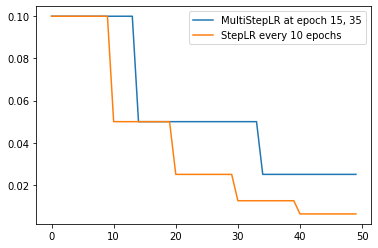

In [9]:
#hide_input
scheduler = MultiStepLRScheduler(optimizer, decay_t=[15, 35], decay_rate=0.5)
plot_lr(scheduler, label='MultiStepLR at epoch 15, 35')

scheduler = StepLRScheduler(optimizer, decay_t=10, decay_rate=0.5)
plot_lr(scheduler, label='StepLR every 10 epochs')
plt.legend();

## Using `MultiStepLRScheduler` scheduler with `timm` training script

To train models using the `MultiStepLRScheduler` we simply update the training script args passed by passing in `--sched multistep` parameter alongside the necessary hyperparams. In this section we will also look at how each of the hyperparams update the `MultiStepLRScheduler` scheduler. 

The training command to use `MultiStepLRScheduler` scheduler looks something like: 

```python 
python train.py ../imagenette2-320/ --sched multistep
```

Availible parameters are: 

--epochs - initial number of epoch to train. default 300.  
--lr - learning rate (default: 0.05)  

--decay-epochs - epoch interval to decay LR , (default: 100), `decay_t` argument in python script   
--decay-rate - LR decay rate (default: 0.1)   


warmup parameters:  
--warmup-lr' - warmup learning rate (default: 0.0001)  
--warmup-epochs - epochs to warmup LR, if scheduler supports (default: 3)  

noise parameters:  
--lr-noise - learning rate noise on/off epoch percentages  
--lr-noise-pct - learning rate noise limit percent (default: 0.67)  
--seed - random seed (default: 42) to seed noise generator.  


## Using in python script.

`MultiStepLRScheduler` accepts two required arguments - an `optimizer` and `decay_t`, and also some hyperparams which we will look into in detail below.

Basic usage like this:


```python 
from timm.scheduler.poly_lr import MultiStepLRScheduler
scheduler = MultiStepLRScheduler(optimizer, decay_t=[step_t, step_t1])
```


### Required arguments.

`optimizer` is object of `torch.optim.Optimizer`  
`decay_t` - list of epochs number to decay LR.

Default schedule:\
Default value for `decay_rate` is 1., so no decay.\
Default parameter for `decay_rate` at train script `--decay-rate` if is 0.1.

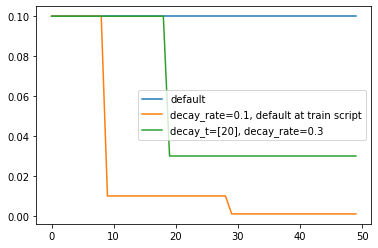

In [10]:
scheduler = MultiStepLRScheduler(optimizer, decay_t=[10, 30])
plot_lr(scheduler, label='default')

scheduler = MultiStepLRScheduler(optimizer, decay_t=[10, 30], decay_rate=0.1)
plot_lr(scheduler, label='decay_rate=0.1, default at train script')

scheduler = MultiStepLRScheduler(optimizer, decay_t=[20], decay_rate=0.3)
plot_lr(scheduler, label='decay_t=[20], decay_rate=0.3')

plt.legend();

### `decay_rate`

`decay_rate` - multiplier for decay learning rate.  So, at every step number at the `decay_t` list, learning rate is decayed by `decay_rate`. If `decay_t=0.5` than at epoch `decay_t[0]` new learning rate will be set to `lr * decay_rate`. And so on on next step at next element from `decay_t`.

By setting `decay_t` = 5 and `decay_rate` = 1., we are telling the schedule to reduce the learning rate by decay_rate where new lr  `lr * decay_rate` every 5 epochs.

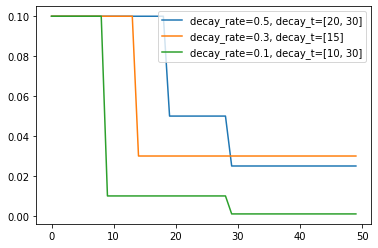

In [11]:
scheduler = MultiStepLRScheduler(optimizer, decay_t=[20, 30], decay_rate=0.5)
plot_lr(scheduler, label='decay_rate=0.5, decay_t=[20, 30]')

scheduler = MultiStepLRScheduler(optimizer, decay_t=[15], decay_rate=0.3)
plot_lr(scheduler, label='decay_rate=0.3, decay_t=[15]')

scheduler = MultiStepLRScheduler(optimizer, decay_t=[10, 30], decay_rate=0.1)
plot_lr(scheduler, label='decay_rate=0.1, decay_t=[10, 30]')
plt.legend();

## Warmup Args.

### `warmup_t` 

Defines the number of warmup epochs. 

### `warmup_lr_init` 

The initial learning rate during warmup. Default is 0.

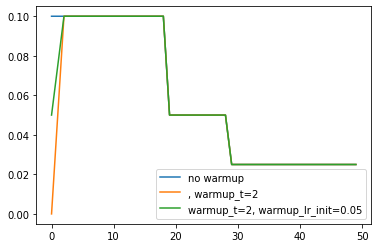

In [12]:
scheduler = MultiStepLRScheduler(optimizer, decay_t=[20, 30], decay_rate=0.5)
plot_lr(scheduler, label='no warmup')

scheduler = MultiStepLRScheduler(optimizer, decay_t=[20, 30], decay_rate=0.5, warmup_t=2)
plot_lr(scheduler, label=', warmup_t=2')

scheduler = MultiStepLRScheduler(optimizer, decay_t=[20, 30], decay_rate=0.5, warmup_t=2, warmup_lr_init=0.05)
plot_lr(scheduler, label='warmup_t=2, warmup_lr_init=0.05')

plt.legend();

As we can see by setting up `warmup_t` and `warmup_lr_init`, the scheduler first starts with a value of `warmup_lr_init`, then during `warmup_t` number of epochs gradually progresses up to the LR value at epoch `warmup_t + 1`.

## Noise Args.

### `noise_range_t`

If it is number - its number of epoch when noise starts.  
If list or tuple (of two elements) - first and second element is epoch number range, when noise applied.

The upper and lower limit of noise. 

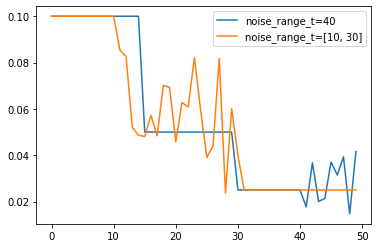

In [13]:
#hide
scheduler = MultiStepLRScheduler(optimizer, decay_t=[15, 30], decay_rate=0.5, noise_range_t=40)
plot_noisy_lr(scheduler, label='noise_range_t=40')

scheduler = MultiStepLRScheduler(optimizer, decay_t=[15, 30], decay_rate=0.5, noise_range_t=[10, 30])
plot_noisy_lr(scheduler, label='noise_range_t=[10, 30]')
plt.legend();

### `noise_pct`

 Percentage of noise to add. 

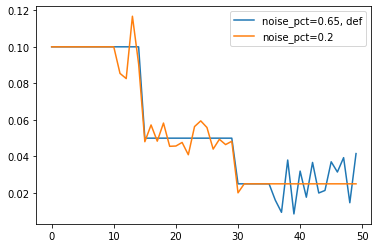

In [14]:
scheduler = MultiStepLRScheduler(optimizer, decay_t=[15, 30], decay_rate=0.5, noise_range_t=35)
plot_noisy_lr(scheduler, label='noise_pct=0.65, def')

scheduler = MultiStepLRScheduler(optimizer, decay_t=[15, 30], decay_rate=0.5, noise_range_t=[10, 30], noise_pct=0.2)
plot_noisy_lr(scheduler, label='noise_pct=0.2')
plt.legend();

### `noise_std`

 Noise standard deviation. Now it is not implemented.

### `noise_seed`

Seed to use to add random noise.

## Miscellaneous.

### `t_in_epochs`


If set to False, the learning rates returned for epoch `t` are `None`.

In [15]:
scheduler = MultiStepLRScheduler(optimizer, decay_t=[0], t_in_epochs=False)
lr_per_epoch = calculate_lr(scheduler, 5)

lr_per_epoch[:5]

[None, None, None, None, None]

### `initialize`

If True, then inside each param group of the `optimizer` a new field is set called `initial_{field_name}` where `field_name` refers to the field in param group that we are scheduling. Typically `field_name='lr'`.